<a href="https://colab.research.google.com/github/Mafasamo/Portafolio/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import warnings
from sklearn.preprocessing import KBinsDiscretizer;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split;
from sklearn.metrics import accuracy_score;
from sklearn.metrics import f1_score,recall_score,precision_score;
from sklearn.compose import ColumnTransformer;
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn import metrics
import matplotlib.pyplot as plt
from torch.utils import data as data_utils

warnings.filterwarnings("ignore")

# Specify the file within the repository
file = "https://raw.githubusercontent.com/Mafasamo/Portafolio/main/Neural%20Networks/weatherAUS.csv"

# Load the CSV file into a DataFrame
raw_data = pd.read_csv(file)
raw_data.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Se verifica si existen valores null en los datos.

In [ ]:
total_nulls = raw_data.isnull().sum().sum()
print("Total number of null values in the DataFrame:", total_nulls)

Total number of null values in the DataFrame: 343248


Se eliminan las filas con valor null en el atributo target, correspondientes al 2.24% del total de filas.  

In [ ]:
null_percentage = raw_data.isnull().mean() * 100

target_null_percentage = null_percentage['RainTomorrow']
print("Null percentage of the target feature (RainTomorrow):", target_null_percentage)

raw_data=raw_data[(raw_data["RainTomorrow"]=="Yes")|(raw_data["RainTomorrow"]=="No")]
raw_data["RainTomorrow"].replace({"No":0,"Yes":1},inplace=True)

raw_data["RainToday"].replace({"No":0,"Yes":1},inplace=True)

Null percentage of the target feature (RainTomorrow): 2.245978275814657


Estudio sobre el porcentaje de valores null según atributo.

In [ ]:
print("Null values percetages by feature:")
print(null_percentage)
null_percentage = null_percentage.drop('RainTomorrow')

target = raw_data[['RainTomorrow']].copy()
raw_data = raw_data.drop(["RainTomorrow"], axis=1)

Null values percetages by feature:
Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64


Se trabaja sobre el atributo categórico "Date", obteniendo el mes y año de cada fecha.

In [ ]:
raw_data["Date"]=pd.to_datetime(raw_data["Date"])
#raw_data["year"]=raw_data["Date"].dt.year
#raw_data["month"]=raw_data["Date"].dt.month
#raw_data["day"]=raw_data["Date"].dt.day

raw_data.insert(0, "month", raw_data["Date"].dt.month)
raw_data.insert(0, "year", raw_data["Date"].dt.year)

raw_data.drop("Date",axis=1,inplace=True)

El conjunto de datos es dividido en dos subconjuntos, uno de entrenamiento y otro de testeo.

In [ ]:
columns = raw_data.columns
X_train, X_test, y_train, y_test = train_test_split(raw_data, target, test_size=0.2, random_state=42, shuffle=True)

Se realiza imputación de valores para los atributos categóricos, utilizando como valor la moda de cada atributo.

In [ ]:
# Impute missing values in columns C and D with mode
mode_WindGustDir = X_train['WindGustDir'].mode()[0]
mode_WindDir9am = X_train['WindDir9am'].mode()[0]
mode_WindDir3pm = X_train['WindDir3pm'].mode()[0]
mode_RainToday = X_train['RainToday'].mode()[0]

# Replace missing values with mode
X_train['WindGustDir'].fillna(mode_WindGustDir, inplace=True)
X_train['WindDir9am'].fillna(mode_WindDir9am, inplace=True)
X_train['WindDir3pm'].fillna(mode_WindDir3pm, inplace=True)
X_train['RainToday'].fillna(mode_RainToday, inplace=True)


Se utiliza el método one hot encoding para representar los atributos categóricos como vectores binarios.  

In [ ]:
# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Get list of numerical columns
numerical_columns = X_train.select_dtypes(include="float64").columns

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the categorical columns
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_columns])

# Get feature names after encoding
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_columns)

# Create DataFrame for encoded features
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Drop original categorical columns from X_train and X_test
X_train = X_train.drop(columns=categorical_columns)
X_test = X_test.drop(columns=categorical_columns)

# Concatenate encoded features with the original non-categorical features
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)
columns = X_train.columns
X_train.head()

,year,month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
18401,2009,10,15.1,23.9,0.0,NaN,NaN,67.0,19.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
127797,2011,9,9.7,14.2,7.6,NaN,NaN,50.0,15.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40012,2010,4,13.2,25.4,0.0,3.2,8.8,30.0,6.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130914,2011,7,7.6,14.8,0.0,4.0,7.0,94.0,30.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41742,2015,4,12.9,22.2,0.0,4.0,7.9,37.0,15.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Para aquellos atributos con un porcentaje de valores null menor a un 10%, se realiza imputación de valores utilizando la media.

In [ ]:
null_percentage = X_train.isnull().mean() * 100
# List of columns you want to perform mean imputation on
mean_imputation_columns = []
for feature in null_percentage.index.tolist():
  if ((null_percentage[feature] > 0) and (null_percentage[feature] <= 15)):
    mean_imputation_columns.append(feature)

print(mean_imputation_columns)

# Calculate mean values for specified columns
mean_values = X_train[mean_imputation_columns].mean()

# Perform mean imputation on specific columns
X_train[mean_imputation_columns] = X_train[mean_imputation_columns].fillna(mean_values)

null_percentage = X_train.isnull().mean() * 100

print("Null values percetages:")
print(null_percentage)
X_train.head()


['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
Null values percetages:
year              0.0
month             0.0
MinTemp           0.0
MaxTemp           0.0
Rainfall          0.0
                 ... 
WindDir3pm_SSW    0.0
WindDir3pm_SW     0.0
WindDir3pm_W      0.0
WindDir3pm_WNW    0.0
WindDir3pm_WSW    0.0
Length: 116, dtype: float64


,year,month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
18401,2009,10,15.1,23.9,0.0,NaN,NaN,67.0,19.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
127797,2011,9,9.7,14.2,7.6,NaN,NaN,50.0,15.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40012,2010,4,13.2,25.4,0.0,3.2,8.8,30.0,6.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130914,2011,7,7.6,14.8,0.0,4.0,7.0,94.0,30.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41742,2015,4,12.9,22.2,0.0,4.0,7.9,37.0,15.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Para imputar valores de atributos con un porcentaje de valores null mayor a un 10% se utilizará el método de regresión lineal.

In [ ]:
def iterative_regression_imputation(data, columns_with_nans):
    # Split data into complete and incomplete parts
    complete_data = data.dropna(subset=columns_with_nans)
    incomplete_data = data[data[columns_with_nans].isnull().any(axis=1)]

    # Iterate through each column with missing values
    for column_with_nan in columns_with_nans:
        # Extract features (including other columns with imputed values)
        features = complete_data.drop(columns_with_nans, axis=1)
        target = complete_data[column_with_nan]

        # Initialize regression model
        regressor = LinearRegression()

        # Train regression model
        regressor.fit(features, target)

        # Extract features for imputation
        features_impute = incomplete_data.drop(columns_with_nans, axis=1)

        # Predict missing values
        imputed_values = regressor.predict(features_impute)

        # Impute missing values
        incomplete_data[column_with_nan] = imputed_values

    # Combine imputed data with complete data
    imputed_data = pd.concat([complete_data, incomplete_data], ignore_index=False)

    return imputed_data

Se realiza la imputacion de valores para aquellos atributos con un porcentaje de valores null mayor a un 10%.

In [ ]:
# Assuming 'columns_with_nans' is a list containing the names of columns with NaN values
columns_with_nans = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']  # Adjust this based on your actual column names

# Perform iterative regression-based imputation
imputed_data = iterative_regression_imputation(X_train, columns_with_nans)
X_train = imputed_data

null_percentage = X_train[numerical_columns].isnull().mean() * 100

print("Numerical column's null values percetages:")
print(null_percentage)

Numerical column's null values percetages:
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustSpeed    0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
dtype: float64


In [ ]:
X_train.head(5)

,year,month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
40012,2010,4,13.2,25.4,0.0,3.2,8.8,30.000000,6.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41742,2015,4,12.9,22.2,0.0,4.0,7.9,37.000000,15.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
109832,2012,6,7.2,15.9,5.6,2.0,2.1,39.957395,9.0,9.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21977,2011,6,13.9,20.6,0.2,2.4,5.6,30.000000,9.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86464,2015,6,10.0,21.1,0.0,3.2,9.5,20.000000,7.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalización de datos.

In [ ]:
X_train_indexes = X_train.index
X_test_indexes = X_test.index
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train_indexes, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test_indexes, columns=X_test.columns)

Se realiza el estudio de la varianza de los atributos, descartanto aquellos que posean una varianza menor a 0.01.

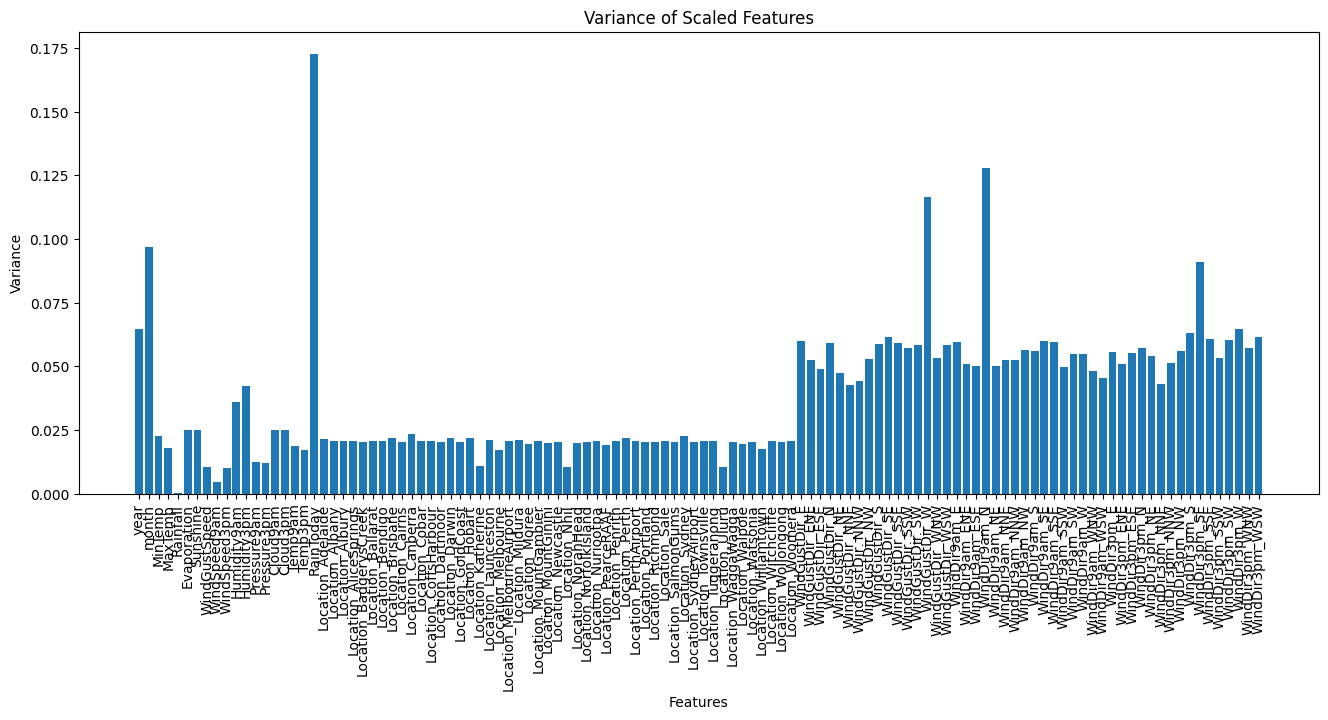

,year,month,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
40012,0.3,0.272727,0.511792,0.570888,0.836074,0.163926,0.186047,0.195402,0.79,0.63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41742,0.8,0.272727,0.504717,0.510397,0.836074,0.163926,0.240310,0.229885,0.69,0.52,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
109832,0.5,0.454545,0.370283,0.391304,0.836074,0.163926,0.263236,0.103448,0.74,0.67,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21977,0.4,0.454545,0.528302,0.480151,0.836074,0.163926,0.186047,0.218391,0.80,0.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86464,0.8,0.454545,0.436321,0.489603,0.836074,0.163926,0.108527,0.080460,0.63,0.46,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Calculate the variance of each feature in the scaled dataframe
variance_values = np.var(X_train, axis=0)

# Create a bar plot to visualize the variance
plt.figure(figsize=(16, 6))
plt.bar(X_train.columns, variance_values)
plt.title('Variance of Scaled Features')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation='vertical')
plt.show()

# Set the variance threshold
threshold = 0.01

# Use VarianceThreshold to select features based on the threshold
selector = VarianceThreshold(threshold)

X_train_modified = selector.fit_transform(X_train)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_indices]
X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]

X_train.head()

Se construye una matriz de correlación con el fin de estudiar las relaciones lineales entre los atributos y el atributo objetivo, asi como también las relaciones lineales entre atributos predictores. Se eliminan aquellos atributos con un coeficiente de correlación bajo (<0.20) con respecto al atributo objetivo (RainTomorrow).

In [ ]:
X_train_modified = X_train.copy()
X_test_modified = X_test.copy()
X_train_modified["RainTomorrow"] = y_train

train_data_correlation = X_train_modified.copy()
#train_data_correlation = pd.get_dummies(train_data_correlation, columns=['Target'], prefix=['Target'])
#train_data_correlation['salary'] = train_data_correlation['salary'].astype('category').cat.codes
correlation_matrix = train_data_correlation.corr()

# Plot heatmap
#plt.figure(figsize=(28, 15))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
#plt.title("Correlation Matrix Heatmap")
#plt.show()

# Calculate point-biserial correlation coefficients with the target
correlations = train_data_correlation.corrwith(train_data_correlation['RainTomorrow']).drop('RainTomorrow')

# Set a correlation coefficient threshold
threshold = 0.20

# Identify features to drop based on the threshold
features_to_drop = correlations[abs(correlations) < threshold].index

# Drop the identified features
train_data = X_train_modified.drop(columns=features_to_drop)

test_data = X_test_modified.drop(columns=features_to_drop)
test_data["RainTomorrow"] = y_test

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
train_data.head()

,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
40012,0.186047,0.79,0.63,0.738843,0.713344,0.0,0
41742,0.240310,0.69,0.52,0.702479,0.708402,0.0,0
109832,0.263236,0.74,0.67,0.520661,0.499176,1.0,1
21977,0.186047,0.80,0.73,0.652893,0.642504,0.0,0
86464,0.108527,0.63,0.46,0.743802,0.742998,0.0,0


In [ ]:
#X_train = pd.concat([X_train, y_train], axis=1)
#X_test = pd.concat([X_test, y_test], axis=1)

X_train = train_data
X_test = test_data

# Initialize MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train.head(5)

,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
0,0.186047,0.79,0.63,0.738843,0.713344,0.0,0.0
1,0.240310,0.69,0.52,0.702479,0.708402,0.0,0.0
2,0.263236,0.74,0.67,0.520661,0.499176,1.0,1.0
3,0.186047,0.80,0.73,0.652893,0.642504,0.0,0.0
4,0.108527,0.63,0.46,0.743802,0.742998,0.0,0.0


In [ ]:
X_test.head(5)

,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
0,0.271318,1.00,0.98,0.350413,0.448105,1.0,1.0
1,0.325581,0.73,0.73,0.778512,0.751236,0.0,0.0
2,0.356589,0.45,0.25,0.819835,0.785832,0.0,0.0
3,0.294574,0.48,0.40,0.540496,0.520593,0.0,0.0
4,0.511628,0.89,0.25,0.433058,0.375618,0.0,1.0


Se construyen los datasets de entrenamiento y testeo a partir de sus respectivos dataframes. A continuación, se divide el conjunto de entrenamiento en dos subconjuntos, uno de entrenamiento y uno de validación.

In [ ]:
batch_size = 64

torch.manual_seed(10) # fijar la semilla para que los resultados sean reproducibles
input_size = X_train.shape[1]

#X_train = torch.tensor(X_train.values)
#X_test = torch.tensor(X_test.values)

original_X_test = X_test.copy()

# Extract target column and create a DataFrame
target_train = pd.DataFrame(X_train['RainTomorrow'])
del X_train['RainTomorrow']

target_test = pd.DataFrame(X_test['RainTomorrow'])
del X_test['RainTomorrow']

array_target_train = np.array(target_train).astype(int)
array_target_train = array_target_train.flatten()
array_target_test = np.array(target_test).astype(int)
array_target_test = array_target_test.flatten()
print(array_target_train)

# Convert DataFrame to PyTorch TensorDataset
train_dataset = data_utils.TensorDataset(torch.Tensor(np.array(X_train)), torch.Tensor(array_target_train).type(torch.LongTensor))

# Split dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
training_data, validation_data = torch.utils.data.random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
print(train_dataset)

# Convert DataFrame to PyTorch TensorDataset
test_dataset = data_utils.TensorDataset(torch.Tensor(np.array(X_test)), torch.Tensor(array_target_test).type(torch.LongTensor))

[0 0 1 ... 1 1 0]


Se construyen los dataloaders de entrenamiento, testeo y validacion, a partir de sus respectivos datasets.

In [ ]:
# Create DataLoader for training data
train_dataloader = data_utils.DataLoader(training_data, batch_size=batch_size, drop_last=False, shuffle=True)
# Create DataLoader for validation data
validation_dataloader = data_utils.DataLoader(validation_data, batch_size=batch_size, drop_last=False, shuffle=False)
# Create DataLoader for testing data
test_dataloader = DataLoader(test_dataset, batch_size=1, drop_last=False, shuffle=True)


Definición de la clase NeuralNetwork. En este caso, el constructor de la clase recibe como parámetros el tamaño de la entrada, el coeficiente de learning rate y de dropout, la cantidad de capas ocultas y el numero de neuronas por capa. Se utilizan los parámetros mencionados anteriormente en el constructor de la clase con el fin de estudiar la mejor arquitectura para la red neuronal. La función de activación utilizada es la función ReLu, mientras que en la capa de salida se utiliza la función Softmax.

In [ ]:
# Definir la clase de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.flatten = nn.Flatten()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        for layer in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_size, 2))
        layers.append(nn.Softmax(dim=1))
        self.layer_stack = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        pred = self.layer_stack(x)
        return pred

Definicion de la funcion de entrenamiento.

In [ ]:
def train(dataloader, model, loss_fn, optimizer, print_loss):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if print_loss:
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Definición de la función de testeo.

In [ ]:
def test(dataloader, model, loss_fn, print_AccuracyAndAvgLoss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = test_loss / num_batches
    correct = correct / size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if print_AccuracyAndAvgLoss:
      print(f"Test Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")
    return (100*correct), test_loss

Se definen los posibles valores de los hiperparámetros. Para cada combinacion posible se construye un modelo y se testea con el conjunto de validación.

Maximum accuracy: 77.8559184211683


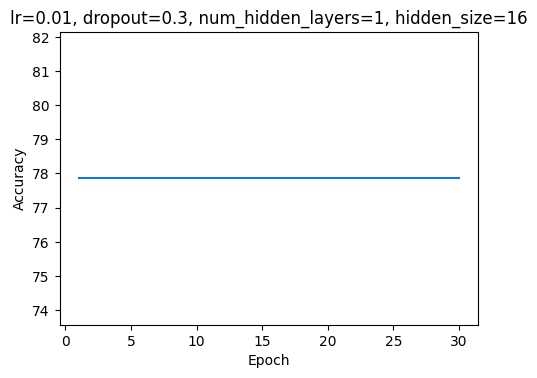

Maximum accuracy: 77.8559184211683


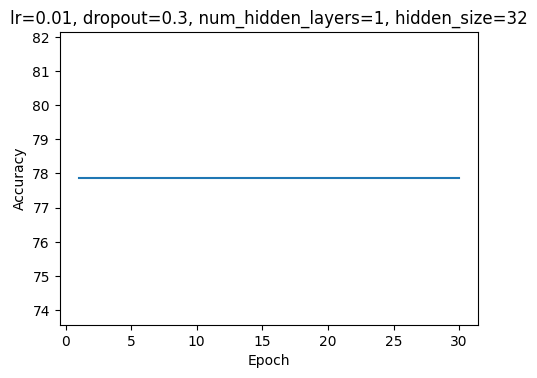

Maximum accuracy: 83.02052657026064


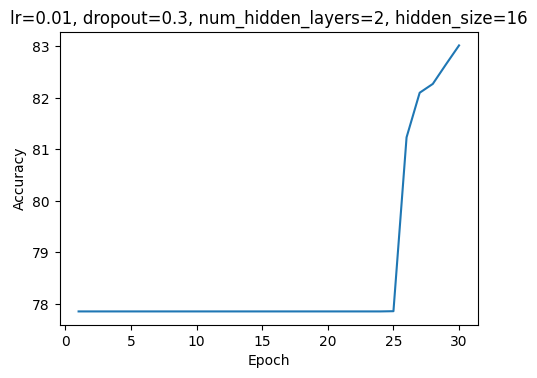

Maximum accuracy: 77.8559184211683


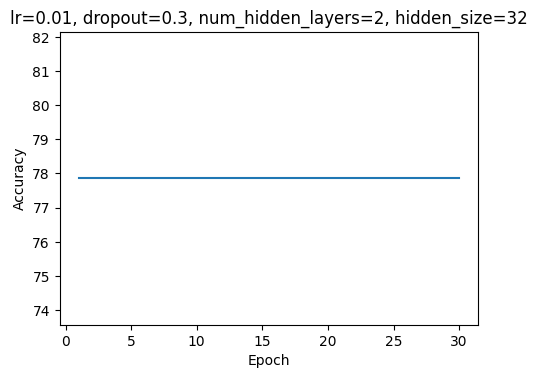

Maximum accuracy: 83.05568985978638


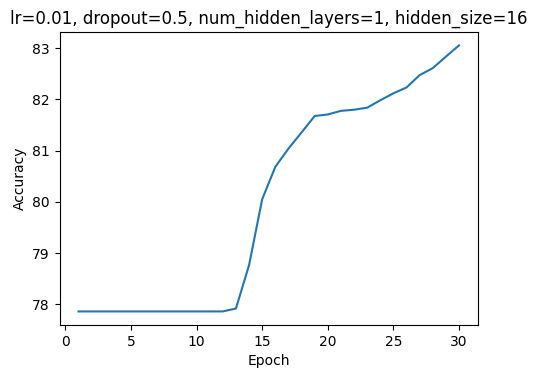

Maximum accuracy: 83.31501912003868


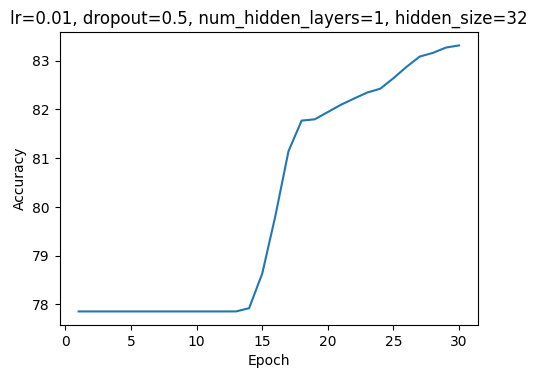

Maximum accuracy: 77.8559184211683


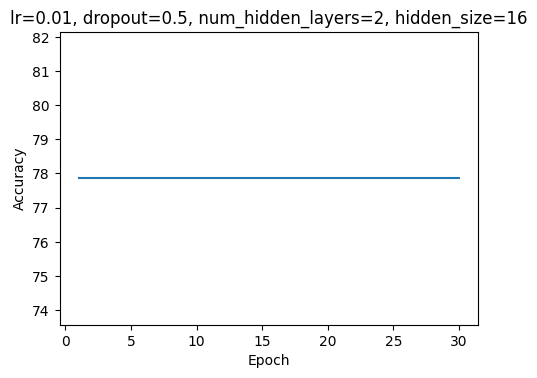

Maximum accuracy: 82.33923783569954


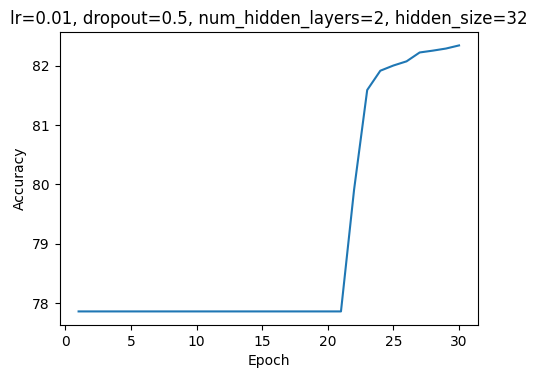

Maximum accuracy: 84.07982066722342


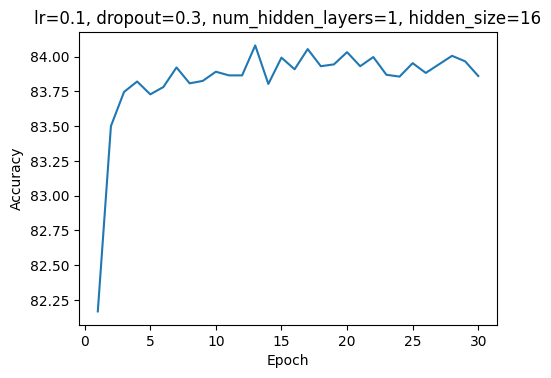

Maximum accuracy: 84.04465737769769


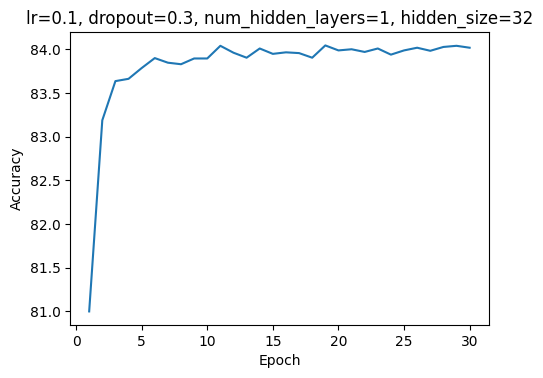

Maximum accuracy: 84.20728759175421


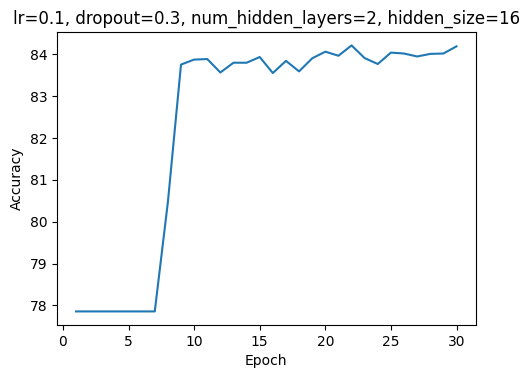

Maximum accuracy: 84.00509867698122


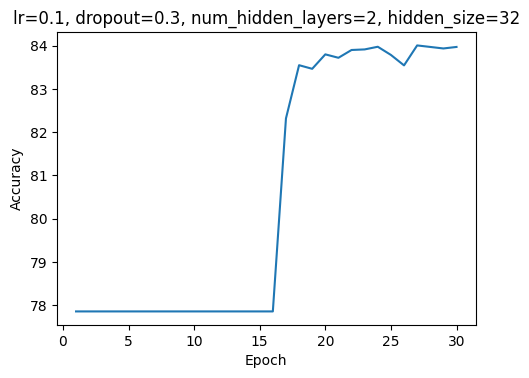

Maximum accuracy: 84.00509867698122


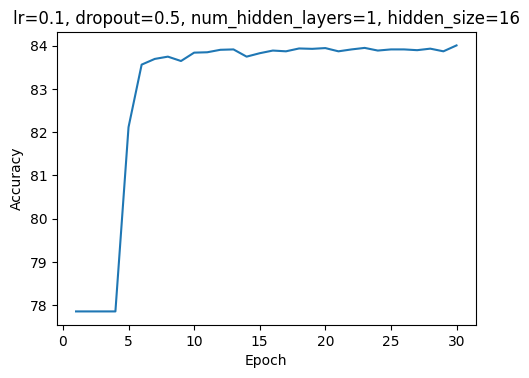

Maximum accuracy: 84.08861148960484


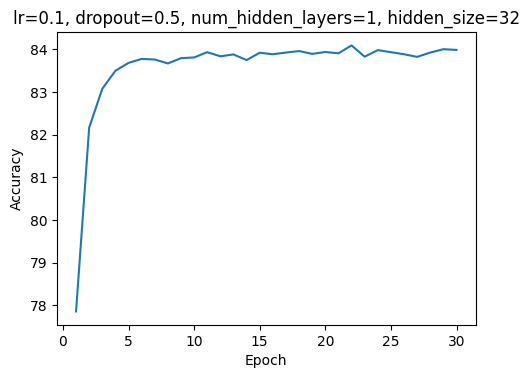

Maximum accuracy: 84.11937936793987


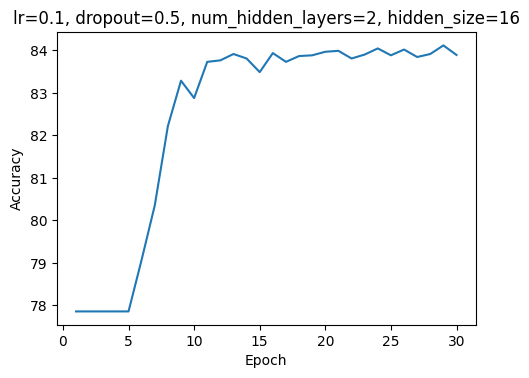

Maximum accuracy: 84.08861148960484


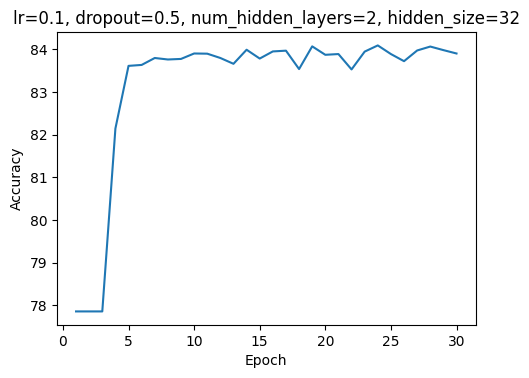

Maximum accuracies for each combination: [77.8559184211683, 77.8559184211683, 83.02052657026064, 77.8559184211683, 83.05568985978638, 83.31501912003868, 77.8559184211683, 82.33923783569954, 84.07982066722342, 84.04465737769769, 84.20728759175421, 84.00509867698122, 84.00509867698122, 84.08861148960484, 84.11937936793987, 84.08861148960484]


In [ ]:
# Hiperparámetros para probar
learning_rates = [0.01, 0.1]
dropouts = [0.3, 0.5]
num_hidden_layers = [1, 2]
hidden_layer_sizes = [16, 32]

combinations = len(learning_rates) * len(dropouts) * len(num_hidden_layers) * len(hidden_layer_sizes)
max_accuracies = []

for lr in learning_rates:
    for dropout in dropouts:
        for num_layers in num_hidden_layers:
            for hidden_size in hidden_layer_sizes:
                #print(f"Training with lr={lr}, dropout={dropout}, num_layers={num_layers}, hidden_size={hidden_size}")
                model = NeuralNetwork(input_size=6, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)

                epochs = 30
                accuracies = []
                for epoch in range(epochs):
                    train(train_dataloader, model, loss_fn, optimizer, False)
                    accuracy, _ = test(validation_dataloader, model, loss_fn, False)
                    accuracies.append(accuracy)
                max_accuracy = max(accuracies)
                max_accuracies.append(max_accuracy)
                print(f"Maximum accuracy: {max_accuracy}")

                # Plot accuracy per epoch
                plt.figure(figsize=(5.4, 3.8))
                plt.plot(range(1, epochs + 1), accuracies)
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.title(f'lr={lr}, dropout={dropout}, num_hidden_layers={num_layers}, hidden_size={hidden_size}')
                plt.show()

print("Maximum accuracies for each combination:", max_accuracies)

In [ ]:
# Definición del modelo
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            #nn.Linear(32, 32),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.Linear(7, 7),
            #nn.ReLU(),
            #nn.Linear(128, 128),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(32, 2),
            nn.Softmax(dim=1)
            #nn.Dropout(0.6),
            #nn.Linear(112, 2),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_sigmoid_stack(x)
        return pred

In [ ]:
model = NeuralNetwork()
#print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # Descenso por gradiente, lr es learning rate

In [ ]:
epochs = 50
accuracies = []
losses = []
print(train_dataloader)
print(enumerate(train_dataloader))
#for i in train_dataloader:
    #print(i)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, False)
    accuracy, loss = test(validation_dataloader, model, loss_fn, False)
    accuracies.append(accuracy)
    losses.append(loss)
print("Done!")

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
----------------

In [ ]:
model.eval()
y_reales = []
y_predicciones = []
with torch.no_grad():
    for index, row in original_X_test.iterrows():
      y_reales.append(row.iloc[-1])
      row_values = row.iloc[:-1]
      row_values = np.array(row_values)
      #row_values = row_values.flatten()
      print(row_values)
      #row_tensor = torch.tensor(row_values)
      #print(row_tensor)
      pred = model(row_values)
      y_predicciones.append(pred.argmax(1).numpy()[0])

[0.27131783 1.         0.98       0.35041322 0.44810544 1.        ]


TypeError: flatten() takes from 0 to 1 positional arguments but 2 were given

In [ ]:
model.eval()
y_reales = []
y_predicciones = []
with torch.no_grad():
    for X, y in test_dataloader:
      #print(X)
      #print(y)
      y_reales.append(y)
      #print(y_reales)
      pred = model(X)
      #print(pred)
      y_predicciones.append(pred.argmax(1).numpy()[0])
      #print(y_predicciones)

In [ ]:
metricas = metrics.classification_report(y_reales,y_predicciones)
print(metricas)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     22098
           1       0.72      0.39      0.51      6341

    accuracy                           0.83     28439
   macro avg       0.78      0.67      0.70     28439
weighted avg       0.82      0.83      0.81     28439

